In [1]:
%pip install pylidc
folder_path = "./ImagesDICOM/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192" 



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:

import pylidc
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

def load_scan(path):
    """Loads all slices from a directory and sorts them by position."""
    # This line now ignores hidden files like .DS_Store
    slices = [pydicom.dcmread(os.path.join(path, s)) 
              for s in os.listdir(path) if s.endswith('.dcm')]
    
    if not slices:
        raise ValueError(f"No .dcm files found in {path}")
        
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

def get_pixels_hu(slices):
    """Converts raw pixel data into Hounsfield Units (HU)."""
    image = np.stack([s.pixel_array for s in slices])
    
    # Convert to int16 (standard for CT)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units using metadata slope and intercept
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# --- EXECUTION ---
# Replace with the path to your downloaded folder of .dcm files
try:
    patient_scan = load_scan(folder_path)
    patient_pixels = get_pixels_hu(patient_scan)

    # Visualize a slice from the middle of the stack
    middle_slice_idx = len(patient_pixels) // 2
    
    plt.figure(figsize=(10, 5))
    
    # Standard Bone/Lung Windowing (approx -1000 to 400 HU)
    plt.imshow(patient_pixels[middle_slice_idx], cmap=plt.cm.bone)
    plt.title(f"Lung CT Slice - Index {middle_slice_idx}")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error: {e}. Make sure the path contains .dcm files.")



'\nimport pylidc\nimport pydicom\nimport os\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndef load_scan(path):\n    """Loads all slices from a directory and sorts them by position."""\n    # This line now ignores hidden files like .DS_Store\n    slices = [pydicom.dcmread(os.path.join(path, s)) \n              for s in os.listdir(path) if s.endswith(\'.dcm\')]\n\n    if not slices:\n        raise ValueError(f"No .dcm files found in {path}")\n\n    slices.sort(key=lambda x: int(x.InstanceNumber))\n    return slices\n\ndef get_pixels_hu(slices):\n    """Converts raw pixel data into Hounsfield Units (HU)."""\n    image = np.stack([s.pixel_array for s in slices])\n\n    # Convert to int16 (standard for CT)\n    image = image.astype(np.int16)\n\n    # Set outside-of-scan pixels to 0\n    # The intercept is usually -1024, so air is approximately 0\n    image[image == -2000] = 0\n\n    # Convert to Hounsfield units using metadata slope and intercept\n    for slice_number in range(len

Patient LIDC-IDRI-0003 has 4 unique nodules.
Loading dicom files ... This may take a moment.
Nodule 1 Characteristics:
 - Malignancy: 2 (1=Low, 5=High)
 - Spiculation: 1
Loading dicom files ... This may take a moment.


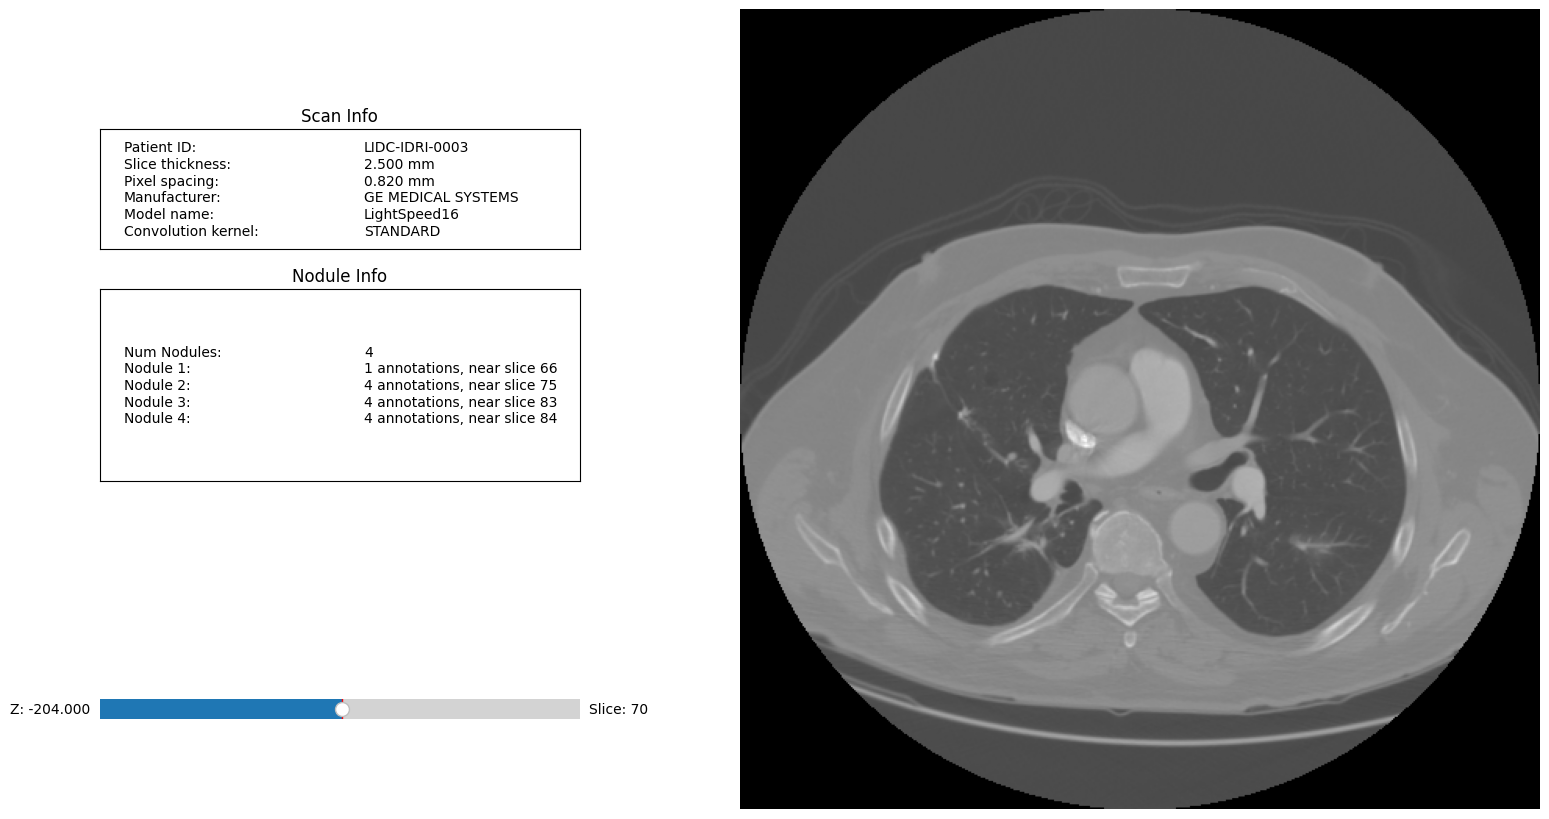

In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np

# 1. Fix compatability between modern NumPy and older pylidc
np.int = int

import configparser

# 2. Fix for Python 3.12+ (SafeConfigParser removed)
if not hasattr(configparser, 'SafeConfigParser'):
    configparser.SafeConfigParser = configparser.ConfigParser


import pylidc as pl
import matplotlib.pyplot as plt

# 1. Query the database for a specific scan
# 'LIDC-IDRI-0001' is the first patient in the dataset
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0003').first()

#import pdb; pdb.set_trace()

# 2. Cluster the annotations
# In LIDC, up to 4 radiologists looked at the same scan.
# cluster_annotations() groups their individual circles into unique 'physical nodules'.
nodules = scan.cluster_annotations()

print(f"Patient {scan.patient_id} has {len(nodules)} unique nodules.")

# 3. Access the 3D volume (The CT scan pixels converted to HU)
vol = scan.to_volume() # This is a 3D NumPy array (Z, Y, X)

# 4. Explore a specific nodule
for i, nodule in enumerate(nodules):
    # 'nodule' is a list of annotations (one from each radiologist)
    # Let's look at the first radiologist's assessment of this nodule
    ann = nodule[0]

    print(f"Nodule {i+1} Characteristics:")
    print(f" - Malignancy: {ann.malignancy} (1=Low, 5=High)")
    print(f" - Spiculation: {ann.spiculation}")

    # 5. Visualize the nodule
    # This creates an interactive GUI (if running locally)
    # that shows the nodule with arrows and contours.
    scan.visualize(annotation_groups=nodules)
    break # Just showing one for this example


In [14]:
'''
#!/usr/bin/env python
# -*- coding: utf-8 -*-


import configparser
import numpy as np
import os
import random
import pylidc as pl

# --- PATCHES ---
if not hasattr(configparser, 'SafeConfigParser'):
    configparser.SafeConfigParser = configparser.ConfigParser
np.int = int
# ---------------


def generate_negative_samples(scan, vol, nodules, num_samples=5, cube_size=32):
    half_size = cube_size // 2
    neg_cubes = []

    # Get all known nodule centers to avoid them
    nodule_centers = [np.mean([ann.centroid for ann in cluster], axis=0) for cluster in nodules]

    attempts = 0
    while len(neg_cubes) < num_samples and attempts < 100:
        attempts += 1

        # 1. Pick a random coordinate (staying away from edges)
        z = random.randint(half_size, vol.shape[0] - half_size)
        y = random.randint(half_size, vol.shape[1] - half_size)
        x = random.randint(half_size, vol.shape[2] - half_size)
        random_center = np.array([z, y, x])

        # 2. Check if this point is too close to any known nodule
        too_close = False
        for node_center in nodule_centers:
            # Calculate Euclidean distance
            dist = np.linalg.norm(random_center - node_center)
            if dist < 40: # 40 pixel buffer
                too_close = True
                break

        # 3. If it's a "clean" area, take the cube
        if not too_close:
            cube = vol[z-half_size : z+half_size,
                       y-half_size : y+half_size,
                       x-half_size : x+half_size]

            # Check if it's mostly empty air (HU around -1000)
            # We want tissue, not just outside the body
            if np.mean(cube) > -900:
                neg_cubes.append((cube, random_center))

    return neg_cubes

# --- EXECUTION ---
output_dir = "LungVoxels/HealthyVoxelData"
os.makedirs(output_dir, exist_ok=True)

# List to keep track of patients that failed
failed_patients = []

for n in range(1, 123):
    patient_id = f"LIDC-IDRI-{n:04d}"
    print(f"--- Processing {patient_id} ---")
    
    try:
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()
        
        if scan is None:
            print(f"Skipping {patient_id}: Not found in database.")
            continue
            
        # The crash happens here; try-except will catch it
        vol = scan.to_volume()
        nodules = scan.cluster_annotations()

        healthy_samples = generate_negative_samples(scan, vol, nodules, num_samples=5)

        for i, (cube, center) in enumerate(healthy_samples):
            file_name = f"{output_dir}/pat{n:04d}_healthy_{i}_label_0.0.npy"
            np.save(file_name, cube)
            
        print(f"Successfully saved 5 cubes for {patient_id}")

    except Exception as e:
        print(f"!!! Error processing {patient_id}: {e}")
        failed_patients.append(patient_id)
        continue

print("--- Processing Complete ---")
if failed_patients:
    print(f"The following patients failed and were skipped: {failed_patients}")
    '''

'\n#!/usr/bin/env python\n# -*- coding: utf-8 -*-\n\n\nimport configparser\nimport numpy as np\nimport os\nimport random\nimport pylidc as pl\n\n# --- PATCHES ---\nif not hasattr(configparser, \'SafeConfigParser\'):\n    configparser.SafeConfigParser = configparser.ConfigParser\nnp.int = int\n# ---------------\n\n\ndef generate_negative_samples(scan, vol, nodules, num_samples=5, cube_size=32):\n    half_size = cube_size // 2\n    neg_cubes = []\n\n    # Get all known nodule centers to avoid them\n    nodule_centers = [np.mean([ann.centroid for ann in cluster], axis=0) for cluster in nodules]\n\n    attempts = 0\n    while len(neg_cubes) < num_samples and attempts < 100:\n        attempts += 1\n\n        # 1. Pick a random coordinate (staying away from edges)\n        z = random.randint(half_size, vol.shape[0] - half_size)\n        y = random.randint(half_size, vol.shape[1] - half_size)\n        x = random.randint(half_size, vol.shape[2] - half_size)\n        random_center = np.array([z

In [15]:
'''
# 1. Fetch the scan
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
vol = scan.to_volume() # The full 3D CT volume

# 2. Get the clusters (the nodules)
nodule_clusters = scan.cluster_annotations()

for i, cluster in enumerate(nodule_clusters):
    # The centroid is the average (Z, Y, X) center of the annotations
    # We convert to integers to use as array indices
    centroid = np.mean([ann.centroid for ann in cluster], axis=0).astype(int)
    z_c, y_c, x_c = centroid
    
    # 3. Define the cube size (32x32x32)
    # We take 16 pixels in each direction from the center
    half_size = 16 
    
    # Slice the 3D volume
    # vol[z_range, y_range, x_range]
    cube = vol[z_c - half_size : z_c + half_size,
               y_c - half_size : y_c + half_size,
               x_c - half_size : x_c + half_size]
    
    # 4. Handle edge cases 
    # (If the nodule is at the very edge, the cube might be smaller than 32x32x32)
    if cube.shape == (32, 32, 32):
        # 5. Get a label (average malignancy score from all radiologists)
        label = np.mean([ann.malignancy for ann in cluster])
        
        # Save the cube and the label
        file_name = f"LungVoxels/NoduleVoxel/pat0001_nodule_{i}_label_{label:.1f}.npy"
        np.save(file_name, cube)
        print(f"Saved Nodule {i} to {file_name} with shape {cube.shape}")
    else:
        print(f"Nodule {i} was too close to the edge of the scan, skipping.")
    '''


'\n# 1. Fetch the scan\nscan = pl.query(pl.Scan).filter(pl.Scan.patient_id == \'LIDC-IDRI-0001\').first()\nvol = scan.to_volume() # The full 3D CT volume\n\n# 2. Get the clusters (the nodules)\nnodule_clusters = scan.cluster_annotations()\n\nfor i, cluster in enumerate(nodule_clusters):\n    # The centroid is the average (Z, Y, X) center of the annotations\n    # We convert to integers to use as array indices\n    centroid = np.mean([ann.centroid for ann in cluster], axis=0).astype(int)\n    z_c, y_c, x_c = centroid\n\n    # 3. Define the cube size (32x32x32)\n    # We take 16 pixels in each direction from the center\n    half_size = 16 \n\n    # Slice the 3D volume\n    # vol[z_range, y_range, x_range]\n    cube = vol[z_c - half_size : z_c + half_size,\n               y_c - half_size : y_c + half_size,\n               x_c - half_size : x_c + half_size]\n\n    # 4. Handle edge cases \n    # (If the nodule is at the very edge, the cube might be smaller than 32x32x32)\n    if cube.shape 

In [16]:
# CREATING HEALTHY CUBE AND NODULE CUBES

import os
import numpy as np
import random
import pandas as pd # Useful for the manifest

BASE_DIR = "LungVoxels"
POS_DIR = os.path.join(BASE_DIR, "NoduleVoxel")
NEG_DIR = os.path.join(BASE_DIR, "HealthyVoxelData")
CUBE_SIZE = 32

os.makedirs(POS_DIR, exist_ok=True)
os.makedirs(NEG_DIR, exist_ok=True)
# Add a directory for masks
MASK_DIR = os.path.join(BASE_DIR, "NoduleMasks")
os.makedirs(MASK_DIR, exist_ok=True)

def generate_mask_patch(scan, cluster, centroid, cube_size=32):
    """
    Creates a 3D binary mask for a nodule centered at a specific centroid.
    
    @params scan: (pylidc.Scan) current CT scan object
    @params cluster: (list) pylidc annotations for nodule
    @params centroid: (tuple) (z, y, x) center of the cube.
    @params cube_size: (int)  size of the output cube (default 32).
    @returns mask_cube: (np.ndarray) Binary 3D array of shape (32, 32, 32).
    """
    half_size = cube_size // 2
    z, y, x = centroid
    
    # 1. Get the consensus mask and its bounding box from pylidc
    # This combines the opinions of all radiologists into one "truth"
    cmask, bbox = pl.utils.consensus(cluster, ret_itrs=False)
    
    # 2. Create a full-volume-sized empty mask (filled with 0s)
    # Using np.bool8 to save memory before cropping
    full_mask = np.zeros(scan.to_volume().shape, dtype=np.bool8)
    full_mask[bbox] = cmask
    
    # 3. Crop the mask using the same centroid as the CT cube
    mask_patch = full_mask[z-half_size:z+half_size, 
                           y-half_size:y+half_size, 
                           x-half_size:x+half_size]
    
    return mask_patch.astype(np.float32)

def generate_positive_samples(vol, clusters, cube_size=32):
    half_size = cube_size // 2
    samples = []
    for cluster in clusters:
        centroid = np.mean([ann.centroid for ann in cluster], axis=0).astype(int)
        z, y, x = centroid
        cube = vol[z-half_size:z+half_size, y-half_size:y+half_size, x-half_size:x+half_size]
        
        if cube.shape == (cube_size, cube_size, cube_size):
            label = np.mean([ann.malignancy for ann in cluster])
            samples.append((cube, label, centroid))
    return samples

def generate_negative_samples(vol, nodules, num_samples=5, cube_size=32):
    half_size = cube_size // 2
    neg_cubes = []
    nodule_centers = [np.mean([ann.centroid for ann in cluster], axis=0) for cluster in nodules]

    attempts = 0
    while len(neg_cubes) < num_samples and attempts < 100:
        attempts += 1
        z = random.randint(half_size, vol.shape[0] - half_size)
        y = random.randint(half_size, vol.shape[1] - half_size)
        x = random.randint(half_size, vol.shape[2] - half_size)
        random_center = np.array([z, y, x])

        # Ensure we aren't near a nodule
        too_close = any(np.linalg.norm(random_center - nc) < 40 for nc in nodule_centers)

        if not too_close:
            cube = vol[z-half_size:z+half_size, y-half_size:y+half_size, x-half_size:x+half_size]
            if np.mean(cube) > -900: # Ensure we are inside the lung/body
                neg_cubes.append((cube, 0.0, random_center)) # Label 0.0 for healthy
    return neg_cubes


manifest = [] # To store file info

for n in range(1, 123):
    patient_id = f"LIDC-IDRI-{n:04d}"
    print(f"--- Processing {patient_id} ---")
    
    try:
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()
        if not scan: continue
        # Optimization: Check if the first healthy file for this patient exists
        check_file = os.path.join(NEG_DIR, f"pat{n:04d}_neg_0_lab_0.0.npy")
        if os.path.exists(check_file):
            print(f"--- Skipping {patient_id}: Already processed ---")
        else:
            vol = scan.to_volume()
            nodules = scan.cluster_annotations()

            
            # Generate both sets
            pos_data = generate_positive_samples(vol, nodules, CUBE_SIZE)
            neg_data = generate_negative_samples(vol, nodules, num_samples=5, cube_size=CUBE_SIZE)
            # Generate the mask
            mask = generate_mask_patch(vol, nodules[i], center, CUBE_SIZE)
            
            # Save the mask
            mask_fname = f"pat{n:04d}_mask_{i}.npy"
            mask_fpath = os.path.join(MASK_DIR, mask_fname)
            np.save(mask_fpath, mask)

            # Save Positive Samples
            for i, (cube, label, center) in enumerate(pos_data):
                fname = f"pat{n:04d}_pos_{i}_lab_{label:.1f}.npy"
                fpath = os.path.join(POS_DIR, fname)
                np.save(fpath, cube)

                # Generate and save mask specifically for THIS positive cube
                mask = generate_mask_patch(scan, nodules[i], center, CUBE_SIZE)
                mask_fname = f"pat{n:04d}_mask_{i}.npy"
                mask_fpath = os.path.join(MASK_DIR, mask_fname)
                np.save(mask_fpath, mask)

                manifest.append({
                    "patient": patient_id, 
                    "file": fname, 
                    "mask_file": mask_fname, 
                    "label": label, 
                    "type": "positive"
                })
            
            # Save Negative Samples
            for i, (cube, label, center) in enumerate(neg_data):
                fname = f"pat{n:04d}_neg_{i}_lab_0.0.npy"
                fpath = os.path.join(NEG_DIR, fname)
                np.save(fpath, cube)

                # Healthy scans don't have masks, so we mark it as None
                manifest.append({
                    "patient": patient_id, 
                    "file": fname, 
                    "mask_file": None, 
                    "label": 0.0, 
                    "type": "negative"
                })


    except Exception as e:
        print(f"Skipping {patient_id} due to error: {e}")

# Save the manifest for easy training later
df = pd.DataFrame(manifest)
df.to_csv("scan_manifest.csv", index=False)
print("Done! All samples saved and scan_manifest.csv created.")

--- Processing LIDC-IDRI-0001 ---
--- Skipping LIDC-IDRI-0001: Already processed ---
--- Processing LIDC-IDRI-0002 ---
--- Skipping LIDC-IDRI-0002: Already processed ---
--- Processing LIDC-IDRI-0003 ---
--- Skipping LIDC-IDRI-0003: Already processed ---
--- Processing LIDC-IDRI-0004 ---
--- Skipping LIDC-IDRI-0004: Already processed ---
--- Processing LIDC-IDRI-0005 ---
--- Skipping LIDC-IDRI-0005: Already processed ---
--- Processing LIDC-IDRI-0006 ---
--- Skipping LIDC-IDRI-0006: Already processed ---
--- Processing LIDC-IDRI-0007 ---
--- Skipping LIDC-IDRI-0007: Already processed ---
--- Processing LIDC-IDRI-0008 ---
--- Skipping LIDC-IDRI-0008: Already processed ---
--- Processing LIDC-IDRI-0009 ---
--- Skipping LIDC-IDRI-0009: Already processed ---
--- Processing LIDC-IDRI-0010 ---
--- Skipping LIDC-IDRI-0010: Already processed ---
--- Processing LIDC-IDRI-0011 ---
--- Skipping LIDC-IDRI-0011: Already processed ---
--- Processing LIDC-IDRI-0012 ---
--- Skipping LIDC-IDRI-0012: Al

**Feeding raw HU values directly into a Neural Network creates two significant technical hurdles:**
1. *Exploding Gradients:* 'Neural networks are mathematically optimized to process data in a small, constrained range (typically $[0.0, 1.0]$ or $[-1.0, 1.0]$). Using large, high-variance integers like $+400$ or $-1000$ can cause "exploding gradients" during backpropagation, making the model's training unstable or preventing it from converging at all.

2. *Filtering Irrelevant Data:* A CT scan captures the entire density spectrum, from empty air to dense cortical bone. When screening for lung cancer, features like rib bones ($+700$ HU) are irrelevant noise that can distract the model.

In [17]:
#NORMALIZING CUBES

import os
import glob
import numpy as np

def normalize_cube(cube):
    """
    Standardizes a 3D CT patch for Deep Learning.
    - Clips values to the Lung Window (-1000 to +400).
    - Scales values to [0.0, 1.0].
    """
    MIN_HU = -1000.0
    MAX_HU = 400.0
    cube = np.clip(cube, MIN_HU, MAX_HU)
    cube = (cube - MIN_HU) / (MAX_HU - MIN_HU)
    return cube.astype(np.float32)

# --- Define Folder Mappings ---
# Format: "Input_Folder": "Output_Folder"
folders_to_process = {
    "LungVoxels/NoduleVoxel": "LungVoxels/NoduleVoxel_normalized",
    "LungVoxels/HealthyVoxelData": "LungVoxels/HealthyVoxelData_normalized"
}


for input_dir, output_dir in folders_to_process.items():
    
    # Setup Directories
    os.makedirs(output_dir, exist_ok=True)
    file_paths = glob.glob(os.path.join(input_dir, "*.npy"))
    
    print(f"\n--- Processing Folder: {input_dir} ---")
    print(f"Found {len(file_paths)} files. Saving to: {output_dir}")

    # Loop through every file in the current folder
    for path in file_paths:
        file_name = os.path.basename(path)
        save_path = os.path.join(output_dir, file_name)

        # Skip if already exists to save time
        if os.path.exists(save_path):
            continue

        try:
            # Load, Normalize, and Save
            raw_cube = np.load(path)
            norm_cube = normalize_cube(raw_cube)
            np.save(save_path, norm_cube)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    print(f"Finished normalizing {input_dir}!")

# Final Verification 
print("\n--- Running Final Verification ---")
for _, output_dir in folders_to_process.items():
    test_files = os.listdir(output_dir)
    if test_files:
        sample_path = os.path.join(output_dir, test_files[0])
        sample = np.load(sample_path)
        print(f"Folder: {output_dir}")
        print(f"  - Sample: {test_files[0]}")
        print(f"  - Range: [{sample.min()}, {sample.max()}]")
        print(f"  - Dtype: {sample.dtype}")


--- Processing Folder: LungVoxels/NoduleVoxel ---
Found 335 files. Saving to: LungVoxels/NoduleVoxel_normalized
Finished normalizing LungVoxels/NoduleVoxel!

--- Processing Folder: LungVoxels/HealthyVoxelData ---
Found 595 files. Saving to: LungVoxels/HealthyVoxelData_normalized
Finished normalizing LungVoxels/HealthyVoxelData!

--- Running Final Verification ---
Folder: LungVoxels/NoduleVoxel_normalized
  - Sample: pat0055_pos_5_lab_3.0.npy
  - Range: [0.059285715222358704, 1.0]
  - Dtype: float32
Folder: LungVoxels/HealthyVoxelData_normalized
  - Sample: pat0101_neg_0_lab_0.0.npy
  - Range: [0.0, 0.8728571534156799]
  - Dtype: float32


In [18]:
import torch
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset

class LungNoduleDataset(Dataset):
    """
    loads 3D lung cubes and their labels from a CSV manifest.
    
    Attributes:
        df (pd.DataFrame) - created from manifest
        pos_dir (str)
        neg_dir (str)
    """

    def __init__(self, csv_file, pos_dir, neg_dir):
        """
        Initializes the dataset.
        
        Args:
            csv_file (str) -- 'scan_manifest.csv'.
            pos_dir (str)
            neg_dir (str)
        """
        self.df = pd.read_csv(csv_file)
        self.pos_dir = pos_dir
        self.neg_dir = neg_dir

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
            int: Total count of files.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Loads a single 3D cube and its label by index.
        
        Args:
            idx (int): The index of the item to retrieve.
            
        Returns:
            cube (torch.Tensor): A 3D tensor of shape (1, 32, 32, 32).
            label (torch.Tensor): A scalar tensor containing the label (0 or 1).
        """
        # get cube from index (CSV row)
        row = self.df.iloc[idx]
        file_name = row['file']
        is_positive = row['type'] == 'positive'
        
        # which folder to look in
        folder = self.pos_dir if is_positive else self.neg_dir
        file_path = os.path.join(folder, file_name)
        
        # load  numpy array
        # It was saved as (32, 32, 32)
        # we need to add a "Channel" dimension (how the image "data" is quantified)
        # PyTorch expects: (Channel, Depth, Height, Width)
        array = np.load(file_path)
        
        # unsqueeze(0) turns (32,32,32) into (1,32,32,32)
        cube = torch.from_numpy(array).unsqueeze(0).float()
        
        # extract malignancy label (healthy= 0.0.) 
        # If it's a nodule, keep the 1-5 rating
        label_value = float(row['label'])
        label = torch.tensor(label_value).float()
        
        return cube, label

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NoduleRegressionModel3D(nn.Module):
    """
    A 3D CNN designed to predict the malignancy 
    severity score (0.0 to 5.0) of a lung volume patch.
    """
    
    def __init__(self):
        """
        Initializes the 3D CNN architecture layers.
        """
        super(NoduleRegressionModel3D, self).__init__()
        
        # feature extraction
        # input layer (1 channel, 32x32x32) -> Output (32 channels)
        # kernel_size=3 with padding=1 keeps the spatial dimensions the same.
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32) # normalizes layer outputs -- expedites training process
        
        # input layer (32 channels) -> Output (64 channels)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        
        # input layer (64 channels) -> Output (128 channels)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        
        # max pooling - reduces spatial size by half (2x2x2)
        # 3 pools == 32x32x32 --> 4x4x4
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2) #translation invariant
                
        # input size: 128 channels * (4 * 4 * 4 voxels) = 8192
        self.fc1 = nn.Linear(128 * 4 * 4 * 4, 256)
        self.dropout = nn.Dropout(p=0.3) # PRevents overfitting by randomly 'dropping off' neurons
        self.fc2 = nn.Linear(256, 1)    # Final output: A single continuous value (the score)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.
        
        Args:
            x (torch.Tensor): A batch of 3D cubes of shape (Batch, 1, 32, 32, 32).
            
        Returns:
            torch.Tensor: A batch of predicted malignancy scores.
        """
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the 3D feature maps into a 1D vector
        x = x.view(x.size(0), -1) 
        
        # Fully connected layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Final Output
        # the raw predicted score (which could be 0.0, 2.5, 4.8, etc.)
        x = self.fc2(x)
        
        return x

In [20]:
'''
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
lungDataset=LungNoduleDataset(scan_manifest.csv,"","")
lungNoduleModel = NoduleRegressionModel3D()
lungNoduleModel.eval()
'''

'\nimport torch\nfrom torchvision import transforms\nfrom PIL import Image\nimport torch.nn as nn\nimport torch.nn.functional as F\nlungDataset=LungNoduleDataset(scan_manifest.csv,"","")\nlungNoduleModel = NoduleRegressionModel3D()\nlungNoduleModel.eval()\n'